## Image Style Transfer

> In this project I implemented [Image Style Transfer proposed by Gatys in 2015](https://arxiv.org/pdf/1508.06576.pdf). The goal is to apply style from one image to different image. Separation of content and style of one image is arguable, but in this procedure we can think of style as colors, textures, brush strokes of image.

<p align='center'>
<img src='https://drive.google.com/uc?id=1-VzIP9_P04PEmgoCpOMXz10YouHuOqKs' width="450" height="300"/>
</p>




For this project I used Convolutional Neural Networks also known as CNNs.
In comparison to other types of neural networks, convolutional neural networks can look at the whole image and analize groups of pixels, while others use individual inputs. Therefore CNNs enable detection of features in space ie. patterns that can appear in pictures. Sequence of convolutional layers with pooling layers create one convolutional neural network.
Convolutional layer apply different filters to compute the output, while pooling layer is used for reducing dimensionality after convolutional layer.

In [0]:
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms, models

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2
import glob

For increasing the efficiency of the network I used GPU computation if it is available.
For comparison, I implemented the method and tried optimizing style transfer with and without the use of GPU. Processing in 2000 epochs it took cca. 4h for target image to be optimized without network running on GPU, while it took no longer than 10 minutes to compute target image with use of GPU.


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
path = 'drive/My Drive/FERI/MAG/TRIR/Projekt'

cuda


Function ``` load_image ``` is used for importing image and transforming it to tensor.
Since pytorchvision models are trained on ImageNet where images are normalized by ``` mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] ```, I use the same normalization statistic in transorming phase.



In [0]:
def load_image(image, max_size=400, shape=None):
  if 'http' in image:
    response = requests.get(image)
    image = Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image = Image.open(image).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape:
    size = shape

  transform = transforms.Compose([transforms.Resize(size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
  
  image = transform(image)[:3,:,:].unsqueeze(0)

  return image.to(device)

In [0]:
content_image = f'{path}/images/content/notre_dame.jpg'
style_image = f'{path}/images/style/starry_night.jpg'
style_name = 'cafe-terrace'

I also created a function ``` image_convert ``` which converts tensor to image after denormalization, so we can display the target image once the process is finished.

In [0]:
def image_convert(tensor):
  
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

In [0]:
content = load_image(content_image)
style = load_image(style_image, shape=content.shape[-2:])

## ---------- show images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))

In [0]:
def save_image(target, style_name):
  denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
  img = target.clone().squeeze()
  img = denorm(img).clamp_(0, 1)

  torchvision.utils.save_image(img, f'{path}/images/{style_name}.png')

I define our own class that uses specific layers of pretrained neural network VGG19.
Only first convolutional layer of each block will be used. On the picture below we can see the architecture of VGG19 and layers used (```conv1_1, con2_1, conv3_1, conv4_1, conv5_1```).

<p align='center'>
<img src='https://drive.google.com/uc?id=1a6Kz3yoTSEsGukDfOsmXL-nSPkNkA4uR' width=80%>
</p>

In [0]:
class Network(nn.Module):

  def __init__(self):
    super(Network, self).__init__()
    self.layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    self.model = models.vgg19(pretrained=True).features

    for params in self.model.parameters():
      params.requires_grad_(False)

  def forward(self, x):
    features = {}
    for name, layer in self.model._modules.items():
      x = layer(x)
      if name in self.layers:
        features[self.layers[name]] = x

    return features

Function ``` gram_matrix ``` calculates correlation between feature maps in one layer. It helps retrieving non-localized information about style, meaning that style does not depend on content.

In [0]:
def gram_matrix(tensor):

  batch_size, num_filters, h, w = tensor.size()
  tensor = tensor.view(num_filters, h*w)
  gram = torch.mm(tensor, tensor.t())

  return gram

I generated the network and forward pass for content and style features. Then gram matrices of each style layer are calculated that will be used in optimization process.
What separates this procedure from other classical use of CNNs in classification is that we do not optimize original image, but create target image that is a clone of content image with white noise and then optimize target image itself.

In [0]:
model = Network().to(device)

content_features = model(content)
style_features = model(style)

style_grams_matrices = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True)
target.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


tensor([[[[ 0.3994,  0.4166,  0.4166,  ..., -1.7240, -1.7069, -1.7240],
          [ 0.3994,  0.4337,  0.4337,  ..., -1.7240, -1.7240, -1.7069],
          [ 0.4508,  0.4679,  0.4679,  ..., -1.7240, -1.7240, -1.7240],
          ...,
          [ 1.1529,  1.1700,  1.1529,  ...,  1.3413,  1.3584,  1.3927],
          [ 1.1700,  1.1529,  1.0502,  ...,  1.3584,  1.3584,  1.3927],
          [ 1.0502,  1.0673,  1.0673,  ...,  1.4440,  1.4440,  1.4440]],

         [[ 0.9755,  0.9755,  0.9580,  ..., -1.1604, -1.1604, -1.1604],
          [ 1.0105,  0.9580,  0.9580,  ..., -1.1604, -1.1604, -1.1429],
          [ 0.9930,  0.9930,  0.9755,  ..., -1.1604, -1.1429, -1.1253],
          ...,
          [ 1.2381,  1.2556,  1.1856,  ...,  1.4832,  1.5357,  1.5882],
          [ 1.2031,  1.1856,  1.0455,  ...,  1.5357,  1.5532,  1.6057],
          [ 1.0105,  1.0455,  1.0630,  ...,  1.6408,  1.6408,  1.6583]],

         [[ 1.8034,  1.8034,  1.7685,  ...,  0.1302,  0.1302,  0.1302],
          [ 1.7685,  1.7685,  

I used Mean Squared Error as a loss function and optimizer Adam with learning rate 0.03. We tried different optimizers such as SGD, but found Adam more efficient in this case.

In [0]:
criterion = nn.MSELoss() # torch.mean((target_features['conv4_2']-content_features['conv4_2']) ** 2)

optimizer = optim.Adam([target], lr = 0.03)

Optimization of target image in one epoch followed the next steps:
  1.   Calculate target image feature maps
  2.   Compare layers conv4_2 of content image and target image to get content loss
  3.   For each layer calculate the difference between style and target representation to get layer and style loss
  4.   Calculate the total loss as weighted sum of style and content loss
  5.   Use the backpropagation step to optimize the target image

We found 2000 epochs sufficient in most of our cases. At the beggining of 
each epoch we put target through forward pass and calculate the content loss as the MSE between content and target features in layer 4_2. We use features of convolutional layer 4_2 as it best represents content while not giving information about style. On the picture below we can see visualized feature maps of each layer (aka what network "sees") for comparison.

<p align='center'>
<img src='https://drive.google.com/uc?id=1cEz3CBDnm7sTXu8lf2v5TkmMvOXETpZF' width=100% alt='Comparison of image through different layers'/>
</p>

For each layer we want network to use we retrieve target feature maps, after which we calculate gram matrix for specific layer and compare it to the style representation of that same layer. Adding some weight it gives us the layer loss. We found giving bigger weights for first layers and smaller for deeper layers gives us better results. We calculate the style loss as sum of layers loss.

Total loss is then the weighted sum of content loss and style loss. We use alpha and beta parameters as content and style weights. Pictures with bigger style effect have smaller alpha/beta ratio. We use total loss in backpropagation step to optimize the target image.

In [0]:
alpha = 1
beta = 1e6

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


for e in range(1, epochs+1):

  target_features = model.forward(target)
  content_loss = criterion(target_features['conv4_2'], content_features['conv4_2'])
  style_loss = 0

  for layer in style_weights:

    target_feature = target_features[layer]
    batch_size, num_filters, h, w = target_feature.shape

    style_gram = style_grams_matrices[layer] # style representation => correlation between different filter responses
    target_gram = gram_matrix(target_feature) # target representation

    layer_loss = style_weights[layer] * criterion(target_gram, style_gram)
    style_loss += layer_loss / (num_filters * h * w)

  total_loss = alpha*content_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f'{e}/{epochs}  Style loss: {style_loss}  Content loss: {content_loss}')
    if e % 500 == 0:
      plt.imshow(image_convert(target))
      plt.show()

save_image(target, 'notre_dame_starry_night')

### Examples of transformations:


<table width='1200px'>
  <tr><th>Content</th><th>Style</th><th>Target</th></tr>
  <tr height='400px'>
    <td><image src='https://drive.google.com/uc?id=1sCEKCDxkA8X0QJrUVANTAcAQ0qAhrnUt' width="400px"/></td>
    <td><image src='https://drive.google.com/uc?id=1w0djIHodJHI0G8xTy43oCw7B1evd583G' width="400px"/></td>
    <td><image src='https://drive.google.com/uc?id=1-2SST3qQWwVDTLv2k-33CoO1fXTdbe1W') width="400px"/></td>
  </tr>
  <tr height='300px'>
  <td><image src='https://drive.google.com/uc?id=101BZQvSJzVaoOC6eQQU9ZLPhVtWWjctf'/></td>
  <td><image src='https://drive.google.com/uc?id=1X1IUn97Hwe8O9sok0mFfuAZZMTEenx5R'/></td>
  <td><image src='https://drive.google.com/uc?id=1-1ouJ-csfQbXxqrNWALJUWpC_g64sgVs'/></td>
  </tr>
  <tr height='300px'>
  <td><image src='https://drive.google.com/uc?id=1CJLhT3TicLRTRLqJvDH9ZVNV12Ditzye'/></td>
  <td><image src='https://drive.google.com/uc?id=1cpG6EmPGg1HJzvm46NttXQfyP64fetfI'/></td>
  <td><image src='https://drive.google.com/uc?id=1-56MpLw51BO4LY7yTafzO7skiYoU3m5d'/></td>
  </tr>
</table>


### Combining styles

Ussing the same procedure, I combined two different styles that are used for creating a target image. Only difference is that we calculated loss of each layer as a weighted sum of layer loss of first style and layer loss of second style.

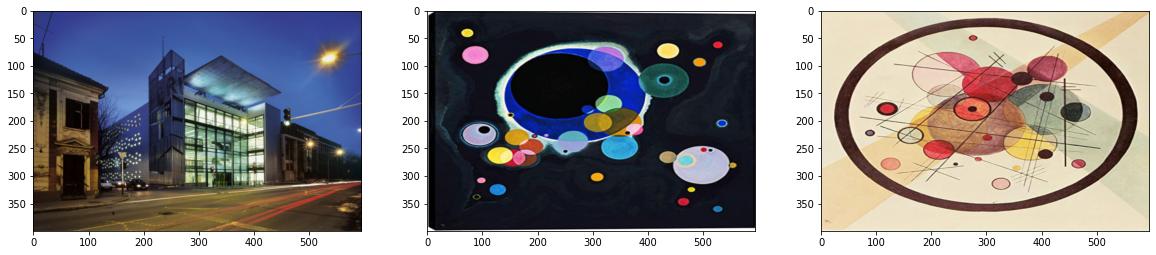

In [0]:
content_image = f'{path}/images/content/feri.jpg'

style_image = f'{path}/images/style/kandinsky_1.jpg'
style_image2 = f'{path}/images/style/kandinsky_2.jpg'

content = load_image(content_image)
style = load_image(style_image, shape=content.shape[-2:])
style2 = load_image(style_image2, shape=content.shape[-2:])

## ---------- show images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))
ax3.imshow(image_convert(style2))

In [0]:
model = Network().to(device)

content_features = model(content)
style_features = model(style)
style2_features = model(style2)

style_grams_matrices = {layer: gram_matrix(style_features[layer]) for layer in style_features}
style2_grams_matrices = {layer: gram_matrix(style2_features[layer]) for layer in style2_features}

target = content.clone().requires_grad_(True)
target.to(device)

tensor([[[[-1.4329, -1.3987, -1.3644,  ..., -1.2788, -1.2959, -1.2959],
          [-1.4158, -1.3815, -1.3644,  ..., -1.2617, -1.2788, -1.2788],
          [-1.3815, -1.3473, -1.3473,  ..., -1.2617, -1.2617, -1.2788],
          ...,
          [-1.3815, -1.3473, -1.3644,  ..., -1.5357, -1.5185, -1.4158],
          [-1.3815, -1.3473, -1.3644,  ..., -1.5870, -1.5699, -1.4158],
          [-1.4329, -1.4158, -1.3815,  ..., -1.6213, -1.6384, -1.4500]],

         [[-1.1429, -1.1078, -1.0903,  ..., -1.0203, -1.0203, -1.0203],
          [-1.1253, -1.1078, -1.0903,  ..., -1.0028, -1.0203, -1.0028],
          [-1.1078, -1.0728, -1.0903,  ..., -1.0028, -1.0028, -1.0203],
          ...,
          [-1.4755, -1.4405, -1.4580,  ..., -1.5805, -1.5630, -1.4930],
          [-1.4755, -1.4405, -1.4580,  ..., -1.6506, -1.6331, -1.5105],
          [-1.5280, -1.5105, -1.4755,  ..., -1.6506, -1.6681, -1.4930]],

         [[-0.3578, -0.3055, -0.2532,  ...,  0.1651,  0.1476,  0.1128],
          [-0.3230, -0.2707, -

50/2000  Style loss: 208.8868865966797  Content loss: 9.489983558654785
100/2000  Style loss: 193.13980102539062  Content loss: 10.548227310180664
150/2000  Style loss: 186.34469604492188  Content loss: 11.118404388427734
200/2000  Style loss: 181.67323303222656  Content loss: 11.51693058013916
250/2000  Style loss: 178.08580017089844  Content loss: 11.855217933654785


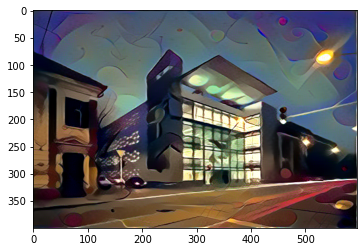

300/2000  Style loss: 175.26327514648438  Content loss: 12.127623558044434
350/2000  Style loss: 173.04335021972656  Content loss: 12.354650497436523
400/2000  Style loss: 171.30088806152344  Content loss: 12.561213493347168
450/2000  Style loss: 169.91285705566406  Content loss: 12.682435989379883
500/2000  Style loss: 168.79620361328125  Content loss: 12.79100513458252


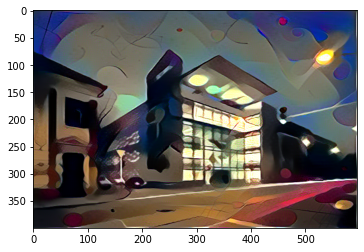

550/2000  Style loss: 167.8367156982422  Content loss: 13.00158405303955
600/2000  Style loss: 167.15354919433594  Content loss: 13.151569366455078
650/2000  Style loss: 166.43096923828125  Content loss: 13.219160079956055
700/2000  Style loss: 165.7142791748047  Content loss: 13.215965270996094
750/2000  Style loss: 167.05081176757812  Content loss: 13.131293296813965


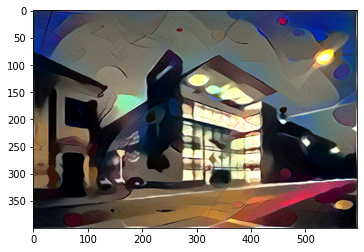

800/2000  Style loss: 164.886962890625  Content loss: 13.3350830078125
850/2000  Style loss: 164.29017639160156  Content loss: 13.476807594299316
900/2000  Style loss: 164.1435089111328  Content loss: 13.460944175720215
950/2000  Style loss: 166.55459594726562  Content loss: 13.45529556274414
1000/2000  Style loss: 164.0347900390625  Content loss: 13.707804679870605


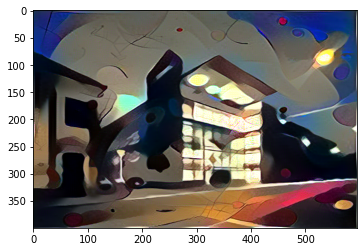

1050/2000  Style loss: 163.17843627929688  Content loss: 13.76904582977295
1100/2000  Style loss: 162.8831329345703  Content loss: 13.841290473937988
1150/2000  Style loss: 162.67889404296875  Content loss: 13.853068351745605
1200/2000  Style loss: 162.5485076904297  Content loss: 13.788128852844238
1250/2000  Style loss: 162.4109344482422  Content loss: 13.900457382202148


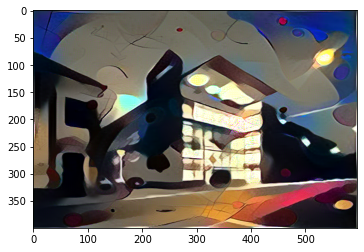

1300/2000  Style loss: 163.32940673828125  Content loss: 13.866037368774414
1350/2000  Style loss: 162.32321166992188  Content loss: 13.99485969543457
1400/2000  Style loss: 161.94540405273438  Content loss: 14.044611930847168
1450/2000  Style loss: 161.93431091308594  Content loss: 14.013139724731445
1500/2000  Style loss: 162.79000854492188  Content loss: 13.77214241027832


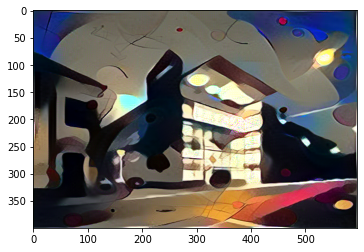

1550/2000  Style loss: 162.93994140625  Content loss: 14.029708862304688
1600/2000  Style loss: 161.7471160888672  Content loss: 14.146571159362793
1650/2000  Style loss: 161.52134704589844  Content loss: 14.173066139221191
1700/2000  Style loss: 161.4015655517578  Content loss: 14.167994499206543
1750/2000  Style loss: 161.3241424560547  Content loss: 14.208481788635254


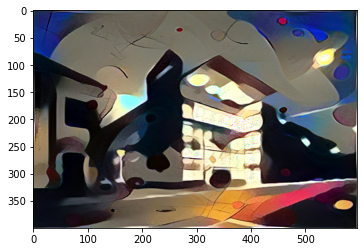

1800/2000  Style loss: 161.27316284179688  Content loss: 14.252039909362793
1850/2000  Style loss: 161.35556030273438  Content loss: 14.261362075805664
1900/2000  Style loss: 162.80233764648438  Content loss: 14.205517768859863
1950/2000  Style loss: 161.1846160888672  Content loss: 14.256153106689453
2000/2000  Style loss: 160.96875  Content loss: 14.249493598937988


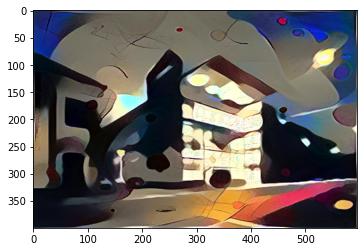

In [0]:
alpha = 1
beta = 1e6

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

style2_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.5,
                 'conv5_1': 0.3}

criterion = nn.MSELoss() # torch.mean((target_features['conv4_2']-content_features['conv4_2']) ** 2)

optimizer = optim.Adam([target], lr = 0.03)


epochs = 2000 #put 2000

for e in range(1, epochs+1):

  target_features = model.forward(target)
  content_loss = criterion(target_features['conv4_2'], content_features['conv4_2'])
  style_loss = 0

  for layer in style_weights:

    target_feature = target_features[layer]
    batch_size, num_filters, h, w = target_feature.shape

    style_gram = style_grams_matrices[layer] # style representation => correlation between different filter responses
    style2_gram = style2_grams_matrices[layer]
    target_gram = gram_matrix(target_feature) # target representation

    layer_loss = style_weights[layer] * criterion(target_gram, style_gram) + style2_weights[layer] * criterion(target_gram, style2_gram)
    style_loss += layer_loss / (num_filters * h * w)

  total_loss = alpha*content_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if e % 50 == 0:
    print(f'{e}/{epochs}  Style loss: {style_loss}  Content loss: {content_loss}')
    if e % 250 == 0:
      plt.imshow(image_convert(target))
      plt.show()

save_image(target, 'multi_styles_feri')

#### Example of style combination

<table width='1400px'>
  <tr><th>Content</th><th>Style 1</th><th>Style 2</th><th>Target</th></tr>
  <tr height='400px'>
  <td><image src='https://drive.google.com/uc?id=1TcUD5T5AWQ0LZr1fy0l_Dqwn8Otrzvk6'></td>
  <td><image src='https://drive.google.com/uc?id=18_La2N8vgTnacgWe9VF72jgUXpctbEJu'/></td>
  <td><image src='https://drive.google.com/uc?id=1w0djIHodJHI0G8xTy43oCw7B1evd583G'/></td>
  <td><image src='https://drive.google.com/uc?id=1-289P-luembGu75kvuXOZydvVGnzSAbm'/></td>
  </tr>
  <tr height='400px'>
  <td><image src='https://drive.google.com/uc?id=1kSIaQ4wXiGBr9E1iGy3pUQUgy4WwQOtN'/></td>
  <td><image src='https://drive.google.com/uc?id=1X1IUn97Hwe8O9sok0mFfuAZZMTEenx5R'/></td>
  <td><image src='https://drive.google.com/uc?id=1u7u31WQoXrmBd1idEv6v1jeWhvTNRjW3'/></td>
  <td><image src='https://drive.google.com/uc?id=1-3V-x010HWP0r6aHFEMXphqoWeUjseCR'/></td>
  </tr>
</table>

### Video Style Transfer

As the results were satisfying, I began thinking about how we can transfer style to videos. Given that video is sequence of images I tried transfering style to a video by processing each frame in already implemented way. It is important to say that optimization method is not the most suitable for video style transfer as the processing takes long time, but it was sufficient for our needs and trying to generate a few examples.

We used OpenCV library for extracting each frame from video and for creating video from stylized frames.

In [0]:
import numpy as np
import glob

vidcap = cv2.VideoCapture(f'{path}/videos/cake.mp4')
success, image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  cv2.imwrite(f'{path}/video_frames/cake/frame%d.jpg' % count, image)     
  if cv2.waitKey(10) == 27:                     
      break
  count += 1

In [0]:
def train(folder_name, model, content_features, style_features, target, style_gram_matrices = None, alpha = 1, beta = 1e6, style_weights = None, epochs = 2000):

  #alpha = 1
  #beta = 1e6

  if style_weights == None:
    style_weights = {'conv1_1': 1.,
                    'conv2_1': 0.8,
                    'conv3_1': 0.5,
                    'conv4_1': 0.3,
                    'conv5_1': 0.1}


  for e in range(1, epochs+1):

    target_features = model.forward(target)
    content_loss = criterion(target_features['conv4_2'], content_features['conv4_2'])
    style_loss = 0

    for layer in style_weights:

      target_feature = target_features[layer]
      batch_size, num_filters, h, w = target_feature.shape

      style_gram = style_grams_matrices[layer] # style representation => correlation between different filter responses
      target_gram = gram_matrix(target_feature) # target representation

      layer_loss = style_weights[layer] * criterion(target_gram, style_gram) #add multiplying by style weight
      style_loss += layer_loss / (num_filters * h * w)

    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if e % 100 == 0:
      print(f'{e}/{epochs}  Style loss: {style_loss}  Content loss: {content_loss}')
      if e % 500 == 0:
        plt.imshow(image_convert(target))
        plt.show()

  print(f'Saving image no. {i} ....')
  save_image(target, folder_name, f'frame{i}')

In [0]:
###---------- train each frame

path_name = 'beach_sun'
image_number ###------------- count images in folder

model = Network().to(device)

style_features = model(style)

style_grams_matrices = {layer: gram_matrix(style_features[layer]) for layer in style_features}

for i in range(image_number):

  content = load_image(f'{path}/video_frames/{path_name}/frame{i}.jpg')

  content_features = model(content)

  target = content.clone().requires_grad_(True)
  target.to(device)

  criterion = nn.MSELoss() # torch.mean((target_features['conv4_2']-content_features['conv4_2']) ** 2)

  optimizer = optim.Adam([target], lr = 0.03)

  train(path_name, model, content_features, style_features, target, style_gram_matrices)

In [0]:
img_array = []
for filename in glob.glob('drive/My Drive/FERI/MAG/TRIR/Projekt/video/stylized_video_frames/beach_sun/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('drive/My Drive/FERI/MAG/TRIR/Projekt/video/stylized_beach_sun.avi', cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


#### Example:

Original video:
https://drive.google.com/file/d/12BpB5jzgSM6Mr8e6-p8EpoSbdEgBYwXf/view?usp=sharing

Style used:
<p>
<img src='https://drive.google.com/uc?id=18_La2N8vgTnacgWe9VF72jgUXpctbEJu' width=30%>
</p>

Stylized video:
https://drive.google.com/file/d/15D4EaQTDfPXzoJ7yNh7ShmThuVTGntXo/view?usp=sharing

<video controls src="https://drive.google.com/uc?id=12BpB5jzgSM6Mr8e6-p8EpoSbdEgBYwXf" />

In [17]:
from IPython.display import HTML

HTML('<iframe src="https://drive.google.com/uc?id=12BpB5jzgSM6Mr8e6-p8EpoSbdEgBYwXf" width="600" height="400"></iframe>')

In [19]:
HTML('<iframe src="https://drive.google.com/uc?id=15D4EaQTDfPXzoJ7yNh7ShmThuVTGntXo" width="600" height="400"></iframe>')